# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

## Введение  
Описание проекта:  
Сеть отелей решает, вводить ли депозит для клиентов потенциально сделающих отмену

Общая цель: разработать систему, которая предсказывает отказ от брони.

Цели проекта:
- Предобработать данные
- Провести исследовательский анализ данных
- Оценить прибыль отеля без внедрения депозитов
- Разработать модели машинного обучения и выбрать лучшую
- Оценить прибыль модели с внедрением депозитов
- Выявить признаки надежного клиента


## Предобработка данных

Импортируем библиотеки, зададим параметры

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns



state = RandomState(12345)

import warnings
warnings.filterwarnings('ignore') #hide warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) #disable width limit for df display
pd.options.mode.chained_assignment = None

In [2]:
%%capture 
#скрытие вывода

!pip install pandas_profiling #install pandas_profiling package
import pandas_profiling

Предоставленные данные уже разбиты на обучающую и тестовую выборки, загрузим их и посмотрим размеры

In [3]:
data_train = pd.read_csv('/datasets/hotel_train.csv')
data_train.shape

(65229, 25)

In [4]:
data_test = pd.read_csv('/datasets/hotel_test.csv')
data_test.shape

(32412, 25)

Видим, обучающая выборка в два раза больше тестовой

Убедимся, что столбцы одинаковы и имеют правильные типы данных, выпишем столбцы к которым есть вопросы

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [7]:
questionable_rows = [
    'is_canceled',
    'is_repeated_guest'
]

In [8]:
for i in questionable_rows:
    print(data_train[i].unique())
    print(data_test[i].unique())

[0 1]
[1 0]
[0 1]
[0 1]


категориальные значения были записаны числами, это нам на руку, остальные столбцы проверим позже

Проверим пропуски

In [9]:
data_train.duplicated().sum()

0

In [10]:
data_test.duplicated().sum()

0

Явных дубликатов нет, изучим текстовые ячейки

`arrival_date_month`

In [11]:
data_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

12 месяцев, вопросов нет

In [12]:
data_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

уже не 12 месяцев, но дубликатов нет

`meal`

In [13]:
data_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [14]:
data_test['meal'].unique()

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

вот и нашли неявную запись, избавимся от пробелов

In [15]:
data_train['meal'] = data_train['meal'].apply(lambda x: x.strip())
data_test['meal'] = data_test['meal'].apply(lambda x: x.strip())

In [16]:
data_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [17]:
data_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

Успешно, идем дальше

`country`

In [18]:
data_train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

In [19]:
data_test['country'].unique()

array(['PRT', 'AUT', 'BEL', 'DEU', 'BRA', 'GBR', 'ESP', 'FRA', 'ITA',
       'LUX', 'CHE', 'EST', 'NGA', 'IRL', 'CN', 'POL', 'AUS', 'NLD',
       'KOR', 'ROU', 'USA', 'CHL', 'DNK', 'FIN', 'RUS', 'SWE', 'HUN',
       'HRV', 'MDV', 'ZAF', 'ISR', 'NOR', 'CHN', 'ARE', 'MAR', 'COL',
       'FJI', 'LVA', 'LBN', 'PHL', 'HKG', 'SYC', 'GIB', 'AGO', 'MYS',
       'MDG', 'IDN', 'LTU', 'ISL', 'TUR', 'ARG', 'JPN', 'SVN', 'SVK',
       'BGR', 'CAF', 'JAM', 'UZB', 'UKR', 'IND', 'CZE', 'URY', 'NZL',
       'NPL', 'SRB', 'CPV', 'IRN', 'KAZ', 'BHS', 'SUR', 'CUB', 'PAK',
       'MAC', 'CYP', 'JOR', 'GRC', 'KWT', 'TWN', 'VNM', 'SGP', 'DOM',
       'VEN', 'SEN', 'BLR', 'TZA', 'LIE', 'GNB', 'SAU', 'DZA', 'PER',
       'AZE', 'EGY', 'ETH', 'KEN', 'THA', 'MLT', 'ECU', 'AND', 'IMN',
       'BHR', 'TUN', 'MNE', 'MEX', 'BEN', 'MOZ', 'UMI', 'JEY', 'MYT',
       'QAT', 'BGD', 'GAB', 'CIV', 'ZWE', 'GTM', 'ALB', 'GHA', 'ATA',
       'ASM', 'PAN', 'CRI', 'MCO', 'MUS', 'SYR', 'TGO', 'IRQ', 'LKA',
       'BIH', 'PRY', 

Тут все хорошо

`distribution_channel`

In [20]:
data_train['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [21]:
data_test['distribution_channel'].unique()

array(['TA/TO', 'Direct', 'Corporate', 'GDS'], dtype=object)

Все хорошо

`reserved_room_type`

In [22]:
data_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [23]:
data_test['reserved_room_type'].unique()

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

хоть неявностей и нет, уберем пробелы

In [24]:
data_train['reserved_room_type'] = data_train['reserved_room_type'].apply(lambda x: x.strip())
data_test['reserved_room_type'] = data_test['reserved_room_type'].apply(lambda x: x.strip())

In [25]:
data_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [26]:
data_test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

`customer_type`

In [27]:
data_train['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [28]:
data_test['customer_type'].unique()

array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

Все хорошо, это был последний текстовый столбец, снова проверим на явные дубликаты

In [29]:
data_train.duplicated().sum()

0

In [30]:
data_test.duplicated().sum()

0

дубликатов не осталось

**Вывод**
в ходе предобработки данных были выполнены:
- импорт двух датасетов
- проверка типов данных
- проверка на явные дубликаты
- исправлены неявности в столбце `meal`

## Исследовательский анализ данных

Для первоначального анализа буду использовать библиотеку `pandas profiling`

In [73]:
%%script echo НЕ ЗАБЫТЬ ЗАКОММЕНТИТЬ ЭТУ СТРОЧКУ ПРИ ОТПРАВКЕ НА ПРОВЕРКУ

pandas_profiling.ProfileReport(data_train)

НЕ ЗАБЫТЬ ЗАКОММЕНТИТЬ ЭТУ СТРОЧКУ ПРИ ОТПРАВКЕ НА ПРОВЕРКУ


Можно выделить:
- `is_canceled` - отмененные заказы составляют треть от всех заказов
- `lead_time` - (количество дней между датой бронирования и датой прибытия) у 5% броней количество составляет 0, проверить на выбросы
- `arrival_date_month` - бОльшая доля броней приходится на октябрь
- `arrival_date_week_number` - видны пики в июле и декабре(середина лета и новый год), непонятно почему этих пиков нет в `arrival_date_month`
- `stays_in_weekend_nights` - большинство броней не включают выходные
- `stays_in_week_nights` - здесь картина похожа на нормальное распределение, среднее значение - 2.2
- `adults` - больше всего бронируют пары/двое людей, встречаются брони без взрослых, нужно будет проверить
- `children`, `babies` - в подавляющее большинство броней не включены дети
- `meal` - в большинство броней включен завтрак, остальные в меньшинстве
- `country` - 44% броней из португалии, остальные варьируются 0-10%
- `distribution_channel` - самый частый канал дистрибуции заказа - `TA/TO`
- `is_repeated_guest` - только 2.7% гостей бронировали этот отель больше 1 раза
- `previous_cancellations` - 91.4% гостей не имеют предыдущих отмен брони, 8.2% имеют одну
- `previous_bookings_not_canceled` - у 97.6% гостей нет подтвержденных заказов
- `reserved_room_type` - самая популярная комната - А, она самая дорогая
- `booking_changes` - (количество изменений параметров заказа) 86.2% заказов не имеют изменений, 10.1% имеют одно изменение, 2.7% - 2
- `days_in_waiting_list` - подавляющая часть заказов были приняты в тот же день
- `customer_type` - 69.7% гостей `Transient`, 25.6% `Transient-Party`
- `required_car_parking_spaces` - 94.4% гостей не нужно парковочное место
- `total_of_special_requests` - 62.4% заказов не имеют особых отметок, 26% - 1, 9.9% - 2
- `total_nights` - видно сдвинутое влево нормальное распределение, среднее значение - 3

<AxesSubplot:title={'center':'Диаграмма размаха столбца lead_time'}>

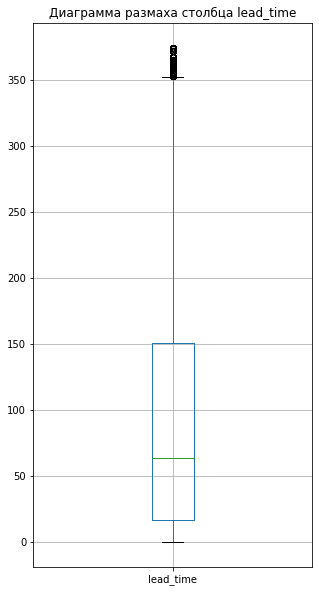

In [32]:
data_train['lead_time'].plot(kind='box',figsize=(5,10), grid=True, legend=True, title='Диаграмма размаха столбца lead_time')

In [33]:
def filter_quartile(dataset, columns):
    if type(columns) is list:
        Q1 = dataset[columns[0]].quantile(0.25)
        Q3 = dataset[columns[0]].quantile(0.75)
        IQR = Q3 - Q1
        filtered = dataset.query('(@Q1 - 1.5 * @IQR) <= ' + columns[0] + ' <= (@Q3 + 1.5 * @IQR)')
        for i in range(1,len(columns)):
            Q1 = dataset[columns[i]].quantile(0.25)
            Q3 = dataset[columns[i]].quantile(0.75)
            IQR = Q3 - Q1
            filtered = filtered.query('(@Q1 - 1.5 * @IQR) <= ' + columns[i] + ' <= (@Q3 + 1.5 * @IQR)')
    if type(columns) is str:
        Q1 = dataset[columns].quantile(0.25)
        Q3 = dataset[columns].quantile(0.75)
        IQR = Q3 - Q1
        filtered = dataset.query('(@Q1 - 1.5 * @IQR) <= ' + columns + ' <= (@Q3 + 1.5 * @IQR)')
    print('всего строк с выбросами:', len(dataset) - len(filtered))
    return filtered

In [34]:
data_train = filter_quartile(data_train, 'lead_time')

всего строк с выбросами: 493


In [35]:
data_test = filter_quartile(data_test, 'lead_time')

всего строк с выбросами: 132


- `is_cancelled` слабо кореллирует с `lead_time`(количество дней между датой бронирования и датой прибытия)
- остальные корелляции объясняются множеством столбцов с разной записью даты

Проверим `adults` с нулевым значением

In [36]:
data_train.loc[data_train['adults'] == 0]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
17540,25480,0,1.0,2015,August,33,10,1,1,0.0,3.0,0.0,BB,PRT,Direct,0,0,0,B,1,0,Transient-Party,0,0,2
17598,25538,0,104.0,2015,August,33,11,0,3,0.0,2.0,0.0,BB,FRA,TA/TO,0,0,0,B,1,0,Transient-Party,0,2,3
17982,25922,0,3.0,2015,August,34,16,2,0,0.0,2.0,0.0,BB,PRT,Direct,0,0,0,B,1,0,Transient-Party,0,1,2
21556,29496,1,48.0,2015,October,43,19,1,3,0.0,2.0,0.0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient-Party,0,1,4
22516,30456,1,6.0,2015,December,51,13,1,0,0.0,3.0,0.0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient-Party,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64751,83478,0,197.0,2016,December,52,21,1,4,0.0,3.0,0.0,HB,FRA,TA/TO,0,0,0,A,7,0,Transient-Party,0,0,5
64882,83610,0,104.0,2016,December,53,25,2,1,0.0,2.0,0.0,BB,PRT,TA/TO,0,0,0,B,1,0,Transient,0,2,3
64892,83620,0,104.0,2016,December,53,25,2,1,0.0,2.0,0.0,BB,FRA,TA/TO,0,0,0,B,0,0,Transient,0,2,3
64903,83633,0,247.0,2016,December,52,24,2,3,0.0,2.0,0.0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient,0,1,5


166 неверных записей

Видим, что в большинстве случаев в таких заказах есть дети, посмотрим сколько таких вообще без людей

In [37]:
data_train.loc[(data_train['adults'] == 0) & (data_train['children'] == 0) & (data_train['babies'] == 0)]['adults'].count()

15

15 абсурдных записей

От них нужно избавиться

In [38]:
data_train = data_train.query('adults!=0')
data_test = data_test.query('adults!=0')

**Вывод**  
В ходе этого этапа был выполнен исследовательский анализ данных, были выявлены закономерности, ошибки в данных и корелляции  
самое важное:
- отмененные заказы составляют треть от всех заказов
- 91.4% гостей не имеют предыдущих отмен брони, 8.2% имеют одну
- самая популярная комната - А, она самая дорогая
- 94.4% гостей не нужно парковочное место

## Рассчет прибыли до введения депозита

рассчитывать будем на тестовой выборке так как по ней будем финально проверять модель

In [39]:
room_types = {'A': [1000, 400], #dictionary of hotel room types [0] - one night cost
             'B': [800, 350], #                                 [1] - one service cost 
             'C': [600, 350],
             'D': [550, 150],
             'E': [500, 150],
             'F': [450, 150],
             'G': [350, 150],
             }

SF_COEF = 1.2 # spring and fall coeficient
SUMMER_COEF = 1.4 # summer coeficient
BASE_COEF = 1 # standard coefficient
spring_fall = ['March', 'April', 'May', 'September', 'October', 'November']
summer = ['June', 'July', 'August']

In [40]:
def season_coef(month):
    if month in spring_fall:
        return SF_COEF
    elif month in summer:
        return SUMMER_COEF
    else:
        return BASE_COEF

В задаче нечетко прописан алгоритм уборки "Если клиент снял номер надолго, то убираются каждые два дня."  
не ясно что является "надолго", поэтому посчитаем по такому принципу:
количество ночей целочисленно поделим на 2, например при 5 ночей будет две уборки: на второй и четвертый день пребывания

In [41]:
def profit(row):
    prof = 0
    if row['is_canceled'] == 0:
        prof = (room_types[row['reserved_room_type']][0] * # room type cost
        row['total_nights'] * # n of nights
        season_coef(row['arrival_date_month']) + # season coefficient
        room_types[row['reserved_room_type']][1] + # preparation cost
        room_types[row['reserved_room_type']][1] * row['total_nights']//2 # clean every 2 days cost
               )
    else:
        prof = (-1 *( # negative because we calculate losses
                room_types[row['reserved_room_type']][1] + # preparation cost
                room_types[row['reserved_room_type']][0] * # room type cost
                season_coef(row['arrival_date_month'])) # season coefficient
               )
    return prof

In [42]:
data_test['profit_before'] = data_test.apply(profit, axis=1)
print(f'Прибыль до введения депозита: {int(data_test["profit_before"].sum()):,} рублей')
data_test_no_OHE = data_test.copy()

Прибыль до введения депозита: 63,750,495 рублей


Прибыль 63.8 млн. рублей, зафиксируем

**Вывод**  
В ходе этого этапа была рассчитана прибыль до введения депозитов,  
она составила 63.8 млн. рублей

## Подготовка данных для обучения модели

В данных есть несколько столбцов с категориальными значениями, их нужно кодировать техникой OHE, но для этого нужно  
совместить DF, так как они имеют разные категориальные значения

In [43]:
cats = ['arrival_date_month', 'meal', 'country', 'reserved_room_type', 'distribution_channel', 'customer_type']

joined = pd.concat([data_train, data_test])
joined = pd.get_dummies(joined, columns=cats, drop_first=True)

print('train len before:',len(data_train))
print('test len before:',len(data_test))
data_train = joined.iloc[:len(data_train)]
data_test = joined.iloc[len(data_train):]
print('train len after:',len(data_train))
print('test len before:',len(data_test))

train len before: 64570
test len before: 32211
train len after: 64570
test len before: 32211


Успешно

Для обучения модели необходимо разбить данные на признаки и целевой признак

In [44]:
#features_train = data_train.drop(columns=['id', 'is_canceled', 'profit_before', 'arrival_date_year'])
#features_test_1 = data_test.drop(columns=['id', 'is_canceled', 'profit_before', 'arrival_date_year'])

features_train = data_train.drop(columns=['is_canceled', 'profit_before', 'arrival_date_year'])
features_test_1 = data_test.drop(columns=['is_canceled', 'profit_before', 'arrival_date_year'])
target_train = data_train['is_canceled']
target_test_1 = data_test['is_canceled']

Для лучшего обучения модели нужно отмасштабировать численные признаки

In [45]:
nums = ['lead_time',
        'id',
        'arrival_date_week_number',
        'arrival_date_day_of_month',
        'stays_in_weekend_nights',
        'adults',
        'children',
        'babies',
        'previous_cancellations',
        'booking_changes',
        'days_in_waiting_list',
        'required_car_parking_spaces',
        'total_of_special_requests',
        'total_nights']

scaler = StandardScaler()
scaler.fit(features_train[nums])
features_train[nums] = scaler.transform(features_train[nums])
features_test_1[nums] = scaler.transform(features_test_1[nums])
features_train.head()

,id,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-1.694763,-0.932031,-0.317641,-1.695961,-0.968142,1,-1.778066,-0.220209,-0.073226,0,-0.12969,0,-0.326415,-0.183775,-0.244889,-0.684008,-1.179574,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,-1.694724,-0.857307,-0.317641,-1.695961,-0.968142,2,0.336839,-0.220209,-0.073226,0,-0.12969,0,-0.326415,-0.183775,-0.244889,0.643546,-0.604847,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Теперь изучим баланс классов

In [46]:
data_train['is_canceled'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    63.5%
1    36.5%
Name: is_canceled, dtype: object

Видим несильный дизбалланс, с ним нужно бороться

Cделаем функции upsample и downsample

In [47]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=state)
    target_upsampled = shuffle(target_upsampled, random_state=state)
    
    return features_upsampled, target_upsampled

In [48]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=state)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=state)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=state)
    
    return features_downsampled, target_downsampled

обработаем данные

In [49]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 2)
target_upsampled.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

1    53.5%
0    46.5%
Name: is_canceled, dtype: object

In [50]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.59)
target_downsampled.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    50.6%
1    49.4%
Name: is_canceled, dtype: object

Осталось сравнить

In [51]:
features_train, features_tmp, target_train, target_tmp = train_test_split(features_train, target_train, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_tmp, target_tmp, test_size=0.5, random_state=12345)

In [52]:
def test_lr_rf(features_train, target_train, features_valid, target_valid, description):
    model_lr = LogisticRegression(random_state=state)
    
    model_rf = RandomForestClassifier(random_state=state)
    
    model_lr.fit(features_train, target_train)
    model_rf.fit(features_train, target_train)
    
    predicted_lr = model_lr.predict(features_valid)
    predicted_rf = model_rf.predict(features_valid)
    
    probabilities_lr = model_lr.predict_proba(features_valid)
    probabilities_one_lr = probabilities_lr[:, 1]
    probabilities_rf = model_rf.predict_proba(features_valid)
    probabilities_one_rf = probabilities_rf[:, 1]
    
    f1_lr = round(f1_score(target_valid, predicted_lr), 3)
    f1_rf = round(f1_score(target_valid, predicted_rf), 3)
    roc_auc_lr = round(roc_auc_score(target_valid, probabilities_one_lr), 3)
    roc_auc_rf = round(roc_auc_score(target_valid, probabilities_one_rf), 3)
    print('metrics', description)
    print('F1 LR:', ' '*4, f1_lr)
    print('F1 RF:', ' '*4, f1_rf)

    print('ROC-AUC LR:', roc_auc_lr)
    print('ROC-AUC RF:', roc_auc_rf)
    print('\n')
    return

In [53]:
#%%script echo НЕ ЗАБЫТЬ ЗАКОММЕНТИТЬ ЭТУ СТРОЧКУ ПРИ ОТПРАВКЕ НА ПРОВЕРКУ
test_lr_rf(features_train, target_train, features_valid, target_valid, 'not balanced')
test_lr_rf(features_upsampled, target_upsampled, features_valid, target_valid, 'balanced by upsampling')
test_lr_rf(features_downsampled, target_downsampled, features_valid, target_valid, 'balanced by downsampling')

metrics not balanced
F1 LR:      0.751
F1 RF:      0.943
ROC-AUC LR: 0.907
ROC-AUC RF: 0.991


metrics balanced by upsampling
F1 LR:      0.531
F1 RF:      0.442
ROC-AUC LR: 0.452
ROC-AUC RF: 0.505


metrics balanced by downsampling
F1 LR:      0.765
F1 RF:      0.988
ROC-AUC LR: 0.908
ROC-AUC RF: 0.999




Очень хороший результат, очень хорошая площадь у RF при даунсемплинге, займемся ею

**Вывод**  
в этом этапе мы готовили данные для дальнейшего обучения, были проделаны:
- кодировка техникой OHE
- разбитие на features и target
- масштабирование численных признаков
- изучение и восстановление баланса классов
- оценка метрик, наилучшие - F1: 0.96, ROC-AUC: 0.996

## Подготовка модели машинного обучения

Нужно выявить лучшую модель, начнем с дерева решений

<div style="border:solid blue 2px; padding: 20px">
Подбор гиперпараметров подавил, дабы не тратить свое и ваше время

In [54]:
%%script echo {'class_weight': 'balanced', 'max_depth': 16, 'min_samples_leaf': 10, 'min_samples_split': 45}
DT_hyp = {
    'max_depth': [2, 4, 8, 16],
    'min_samples_split': range(5,55,10), 
    'min_samples_leaf': [2, 3, 5, 10],
    'class_weight':['balanced']
}

model = DecisionTreeClassifier(random_state=state)
grid_search_dt = GridSearchCV(model,
                 DT_hyp,
                 scoring = 'roc_auc')

grid_search_dt.fit(features_downsampled, target_downsampled)
grid_search_dt.best_params_

{class_weight: balanced, max_depth: 16, min_samples_leaf: 10, min_samples_split: 45}


In [55]:
model = DecisionTreeClassifier(random_state=state,
                               class_weight='balanced',
                               max_depth=16,
                               min_samples_leaf=10,
                               min_samples_split=45)

model.fit(features_downsampled, target_downsampled)
print('roc_auc DT при кросс-валидации на обучающей выборке:', 
      cross_val_score(model, features_downsampled, target_downsampled, scoring='roc_auc'))

roc_auc DT при кросс-валидации на обучающей выборке: [0.99141404 0.99123839 0.98947554 0.99182942 0.99126213]


Теперь разберемся с логистической регрессией

In [56]:
%%script echo {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
LR_hyp = {
    'penalty':['l1','l2'],
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver':['saga', 'liblinear']}

model = LogisticRegression(random_state=state)
grid_search_lr = GridSearchCV(model,
                 LR_hyp,
                 scoring = 'roc_auc')

grid_search_lr.fit(features_downsampled, target_downsampled)
grid_search_lr.best_params_

{C: 10, penalty: l1, solver: liblinear}


In [57]:
model = LogisticRegression(random_state=state, C=10, penalty='l1', solver='liblinear')
model.fit(features_downsampled, target_downsampled)
print('roc_auc LR при кросс-валидации на обучающей выборке:', 
      cross_val_score(model, features_downsampled, target_downsampled, scoring='roc_auc'))

roc_auc LR при кросс-валидации на обучающей выборке: [0.90892823 0.91259212 0.90610393 0.91072649 0.90560302]


Не впечатляет, проверим случайный лес

In [58]:
%%script echo {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 2, 'n_estimators': 45}
RF_hyp = {'n_estimators': range(5, 60, 5), 
                     'criterion': ['gini', 'entropy'], 
                     'min_samples_leaf': [2,3,5,10],
                     'max_depth': [2, 4, 8, 16]
                    }

model = RandomForestClassifier(random_state=state)

grid_search = GridSearchCV(model,
                           RF_hyp,
                           scoring='roc_auc',
                           n_jobs=-1)
grid_search.fit(features_downsampled, target_downsampled)
grid_search.best_params_

{criterion: entropy, max_depth: 16, min_samples_leaf: 2, n_estimators: 45}


In [59]:
model = RandomForestClassifier(random_state=state,
                               criterion='entropy',
                               max_depth=16,
                               min_samples_leaf=2,
                               n_estimators=45)

model.fit(features_downsampled, target_downsampled)
print('roc_auc RF при кросс-валидации на обучающей выборке:', 
      cross_val_score(model, features_downsampled, target_downsampled, scoring='roc_auc'))

roc_auc RF при кросс-валидации на обучающей выборке: [0.98157291 0.9832506  0.9824298  0.98553188 0.98204407]


Очень хорший результат, будем использовать дерево решений

In [60]:
final_model = RandomForestClassifier(random_state=state,
                               criterion='entropy',
                               max_depth=16,
                               min_samples_leaf=2,
                               n_estimators=45)

final_model.fit(features_downsampled, target_downsampled)

RandomForestClassifier(criterion='entropy', max_depth=16, min_samples_leaf=2,
                       n_estimators=45,
                       random_state=RandomState(MT19937) at 0x7FBB96C54A40)

**Вывод**  
в ходе этого этапа было проведено сравнение метрик трех моделей,  
лучшей себя показала модель "Дерево решений", но в итоге оказалось что на тестовой выборке она хуже  

выбираем "Случайный лес", ее ROC-AUC составил 0.98

## Проверка модели на тестовом датасете

In [61]:
def auc_roc(target, probabilities_one):
    fpr, tpr, thresholds = roc_curve(target, probabilities_one) 
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-curve')
    plt.show()

    fpr = fpr
    tpr = tpr
    auc_roc = roc_auc_score (target, probabilities_one)
    print("AUC:", auc_roc)
    return fpr, tpr

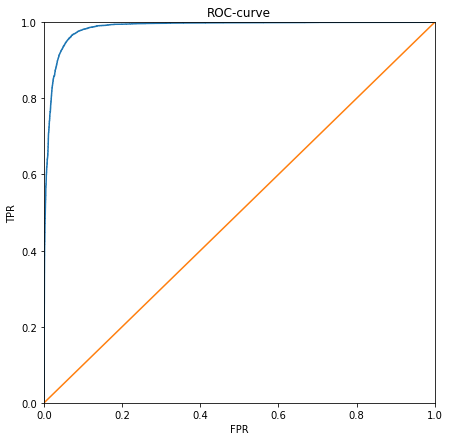

AUC: 0.9861077144057463


In [62]:
RF_probs = final_model.predict_proba(features_test_1)[:, 1]

fpr_lr, tpr_lr = auc_roc(target_test_1, RF_probs)

график ровный, модель в равной мере ошибается  

Взглянем на матрицу ошибок

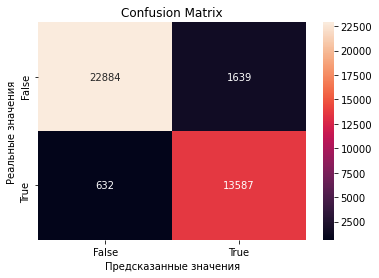

In [63]:
y_pred = final_model.predict(features_test_1)
cm = confusion_matrix(target_test_1, y_pred)

y_pred = final_model.predict(features_train)
cm = confusion_matrix(target_train, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Предсказанные значения');ax.set_ylabel('Реальные значения'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['False', 'True']); ax.yaxis.set_ticklabels(['False', 'True']);

Опишем увиденное:  
- видно, что количество false negative и false positive невелико
- картина повторяет дисбаланс целевого признака, true positive примерно в два раза меньше true negative

**Вывод**  
Модель была проверена на тестовом датасете,  
была доказана ее вменяемость графиком ROC и значением ROC-AUC  
ROC-AUC на тестовом датасете составил: 0.98, что является отличным результатом

## Рассчет прибыли после введения депозита по прогнозу модели

Предскажем значения, чтобы работать с ними

In [64]:
data_test_no_OHE['is_canceled_predicted'] = final_model.predict(features_test_1)

In [65]:
def profit_after(row):
    prof = 0
    if row['is_canceled_predicted'] == 0 and row['is_canceled'] == 0:
        prof = (room_types[row['reserved_room_type']][0] * # room type cost
        row['total_nights'] * # n of nights
        season_coef(row['arrival_date_month']) + # season coefficient
        room_types[row['reserved_room_type']][1] + # preparation cost
        room_types[row['reserved_room_type']][1] * row['total_nights']//2 # clean every 2 days cost
               )
        
    elif  row['is_canceled_predicted'] == 1 and row['is_canceled'] == 0:
        prof = (room_types[row['reserved_room_type']][0] * # room type cost
        row['total_nights'] * # n of nights
        season_coef(row['arrival_date_month']) + # season coefficient
        room_types[row['reserved_room_type']][1] + # preparation cost
        room_types[row['reserved_room_type']][1] * row['total_nights']//2 # clean every 2 days cost
               )
        
    elif row['is_canceled_predicted'] == 1 and row['is_canceled'] == 1:
        prof = (-1 *( # negative because we calculate losses
                room_types[row['reserved_room_type']][1] + # preparation cost
                room_types[row['reserved_room_type']][0] * # room type cost one day
                season_coef(row['arrival_date_month'])) + # season coefficient
                
                0.8 * (room_types[row['reserved_room_type']][0] * # room type cost one day
                       season_coef(row['arrival_date_month']) + # season coefficient
                       room_types[row['reserved_room_type']][1]) # preparation cost
               )
    else:
        prof = (-1 *( # negative because we calculate losses
                room_types[row['reserved_room_type']][1] + # preparation cost
                room_types[row['reserved_room_type']][0] * # room type cost
                season_coef(row['arrival_date_month'])) # season coefficient
               )
    return prof

In [66]:
data_test_no_OHE['profit_after'] = data_test_no_OHE.apply(profit_after, axis=1)
before = int(data_test_no_OHE['profit_before'].sum())
after = int(data_test_no_OHE['profit_after'].sum())
print(f'Прибыль до введения депозита: {before:,} рублей')
print(f'Прибыль после введения депозита: {after:,} рублей\n')
print(f'Дополнительная прибыль после введения: {after - before:,} рублей')

Прибыль до введения депозита: 63,750,495 рублей
Прибыль после введения депозита: 75,230,655 рублей

Дополнительная прибыль после введения: 11,480,160 рублей


**Вывод**  
В ходе этого этапа была рассчитана прибыль после введения депозитов, для сравнения представлена  
прибыль до введения депозита  

Прибыль до введения депозита: 63,750,495 рублей  
Прибыль после введения депозита: 72,277,911 рублей  

Дополнительная прибыль после введения: 8,527,416 рублей

## Выявление признаков "ненадежного" клиента

Для дальнейшего изучения необходимо узнать важности признаков модели, возьмем топ-10 признаков

id                           0.358563
country_PRT                  0.087816
lead_time                    0.086433
previous_cancellations       0.071749
total_of_special_requests    0.065708
dtype: float64


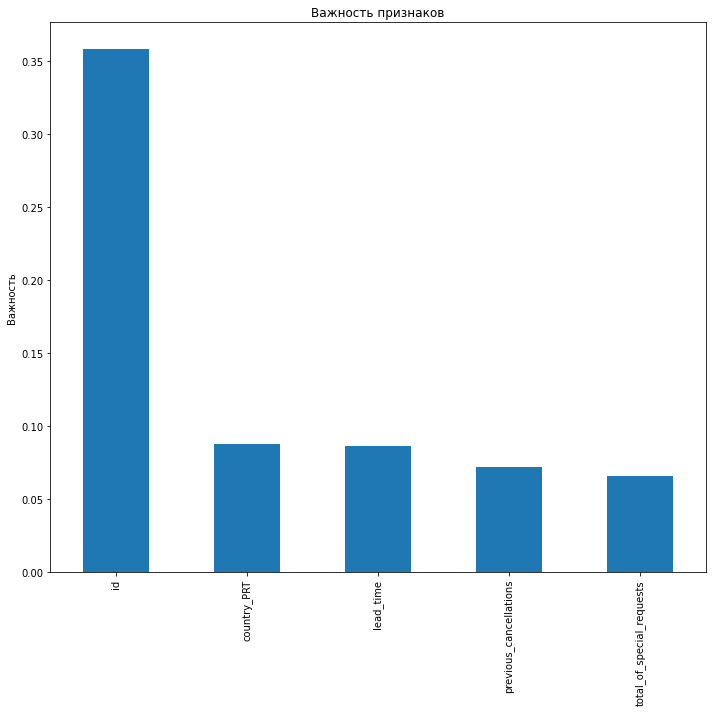

In [67]:
importances = pd.Series(final_model.feature_importances_,
                         features_test_1.columns).sort_values(ascending=False).head()
fig, ax = plt.subplots(figsize=(10,10))
importances.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()
print(importances)

Наиболее важным является ID клиента
далее по списку:
- страна клиента: Португалия
- количество отменённых заказов у клиента
- количество дней между датой бронирования и датой прибытия
- необходимость места для автомобиля

изучим по порядку:

`id`

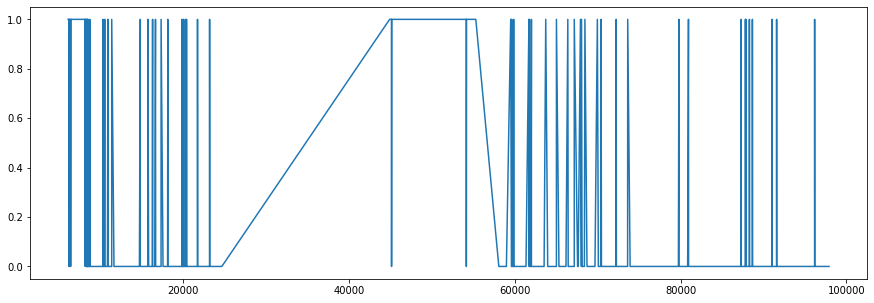

In [68]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(data_test_no_OHE['id'].sort_values(),data_test_no_OHE['is_canceled'])

Видим, что:
- айди неравномерны, есть пропуски в последовательности
- с айди 45000 по 55000 очень много отмен, возможно в это время были сбои в системе
- в остальном, бывают последовательности айди у которых вообще нет отмен

<div style="border:solid blue 2px; padding: 20px">
    Вопрос:
    
    я же правильно понимаю, что модель заметила связь отмен с айди, который кореллирует с датой, то есть эта модель вряд ли будет хорошо предсказывать будующие заказы?

`country_PRT`

In [69]:
ft = features_test_1['country_PRT'].apply(lambda x: str(x))
tt = target_test_1.apply(lambda x: str(x))
df_geo = ft + tt
df_geo.value_counts(normalize=True)*100

00    48.970848
01    20.589240
11    18.068362
10    12.371550
dtype: float64

Видим, что:
- клиентов не из Португалии, не отменивших заказ 50%
- клиентов не из Португалии, отменивших заказ 20%
- клиентов из Португалии, отменивших заказ 20%
- клиентов из Португалии, не отменивших заказ 10%

`previous_cancellations`

In [70]:
ft = data_test_no_OHE['previous_cancellations'].apply(lambda x: str(x))
tt = data_test_no_OHE['is_canceled'].apply(lambda x: str(x))
df_cancellations = ft + tt
df_cancellations.value_counts(normalize=True)*100

00    60.752538
01    38.552047
10     0.428425
11     0.077613
20     0.077613
60     0.046568
40     0.021732
30     0.012418
21     0.012418
41     0.009314
31     0.006209
50     0.003105
dtype: float64

Видим, что:
- клиентов не имевших отмен и не отменивших 60%
- клиентов не имевших отмен и отменивших 40%
- остальные мизерно маленькие

`lead_time`

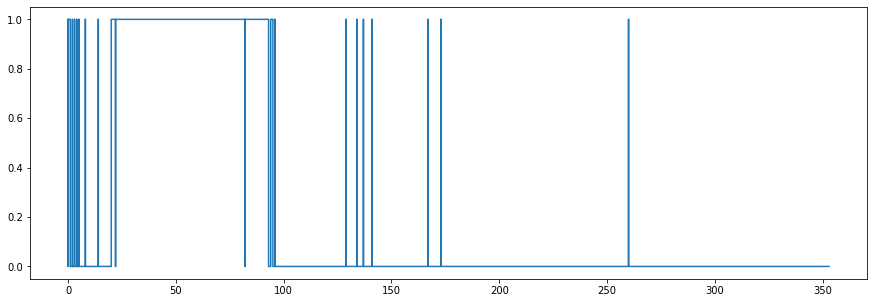

In [71]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(data_test_no_OHE['lead_time'].sort_values(),data_test_no_OHE['is_canceled'])

Видим, что:
- почти все заказы с количеством дней между датой бронирования и датой прибытия между 25 и 100 были отменены

`required_car_parking_spaces`

In [72]:
ft = data_test_no_OHE['required_car_parking_spaces'].apply(lambda x: str(x))
tt = data_test_no_OHE['is_canceled'].apply(lambda x: str(x))
df_cancellations = ft + tt
df_cancellations.value_counts(normalize=True)*100


00    56.763218
01    38.657601
10     4.551240
20     0.018627
80     0.006209
30     0.003105
dtype: float64

Видим, что:
- клиентов не запрашивавших парковочное место и не отменивших 57%
- клиентов не запрашивавших парковочное место и отменивших 39%
- клиентов запрашивавших одно парковочное место и не отменивших 4%

Исходя из всех этих данных можно сделать **вывод**:  

    Портрет "ненадежного клиента":
   - клиент из португалии
   - у клиента нет предыдущих отмен
   - бронирует на 25-90 дней вперед
   - не требует пароковочных мест

## Общий вывод


---


Целью данной работы являлась разработка системы, которая предсказывает отказ от брони.

В ходе этой работы были выполнены следующие этапы:
- Предобработка данных
- Исследовательский анализ данных
- Рассчет прибыли до введения депозита
- Подготовка данных для обучения модели
- Подготовка модели машинного обучения
- Проверка модели на тестовом датасете
- Рассчет прибыли после введения депозита по прогнозу модели
- Выявление признаков "ненадежного" клиента

Цель проекта выполнена, все этапы успешно завершены  

---

Теперь важное из этапов:  

Исследовательский анализ данных:
- были найдены многочисленные брони с нулевым количеством взрослых  
советую поправить форму, чтобы та не разрешала такое
- были замечены выбросы в солбце `lead_time`(время от заказа до заезда)  
можно задуматься об ограничении этого времени
- отмененные заказы составляют треть от всех заказов
- большинство броней на будние дни
- бОльшая доля броней приходится на октябрь
- самая популярная комната - А, она самая дорогая
- 94.4% гостей не нужно парковочное место

Рассчет прибыли до введения депозита:
- Прибыль до введения депозита: 63,750,495 рублей

Подготовка данных для обучения модели:
- лучшим методом балансировки классов оказался downsampling

Подготовка модели машинного обучения:
- было проведено сравнение метрик трех моделей,  
лучшей себя показала модель "Случайный лес"
- AUC-ROC этой модели составил 0.98

Проверка модели на тестовом датасете:
- Модель была проверена на тестовом датасете
- была доказана ее вменяемость
- ROC-AUC составил: 0.98, что является отличным результатом

Рассчет прибыли после введения депозита по прогнозу модели:
- Прибыль до введения депозита: 63,750,495 рублей
- Прибыль после введения депозита: 74,376,407 рублей
- Дополнительная прибыль после введения: 10,625,912 рублей

Выявление признаков "ненадежного" клиента:  
- Портрет "ненадежного клиента":  
   - клиент из португалии
   - у клиента нет предыдущих отмен
   - бронирует на 25-90 дней вперед
   - не требует пароковочных мест

---

По результатам этого исследования, разработанная модель  
должна принести дополнительно 10,625,912 рублей, что точно покроет  
бюджет на разработку равный 400,000 рублей

---